In [8]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase, mean_over_ranges

import itertools
import random as rd
from typing import List, Tuple

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length_vanilla_and_embedding = 256
model_max_length_prompt = 512
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length_vanilla_and_embedding)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension,model_max_length = model_max_length_prompt)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size,model_max_length = model_max_length_vanilla_and_embedding)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
vanilla_hidden_states_df = vanilla_bert_only_classifier.forward_dataset_and_save_outputs(dataset_vanilla)
prompt_hidden_states_df = prompt_bert_only_classifier.forward_dataset_and_save_outputs(dataset_prompt)
adding_embedding_hidden_states_df = adding_embedding_bert_only_classifier.forward_dataset_and_save_outputs(dataset_adding_embedding)

In [4]:
vanilla_hidden_states = torch.stack(vanilla_hidden_states_df[vanilla_hidden_states_df["split"] == "train"]["hidden_states"].tolist())
prompt_hidden_states = torch.stack(prompt_hidden_states_df[prompt_hidden_states_df["split"] == "train"]["hidden_states"].tolist())
adding_embedding_hidden_states = torch.stack(adding_embedding_hidden_states_df[adding_embedding_hidden_states_df["split"] == "train"]["hidden_states"].tolist())

In [5]:
vanilla_pcas = vanilla_bert_only_classifier.init_pca(vanilla_hidden_states)
prompt_pcas = prompt_bert_only_classifier.init_pca(prompt_hidden_states)
adding_embedding_pcas = adding_embedding_bert_only_classifier.init_pca(adding_embedding_hidden_states)

(10, 3, 2) (10, 5, 2)


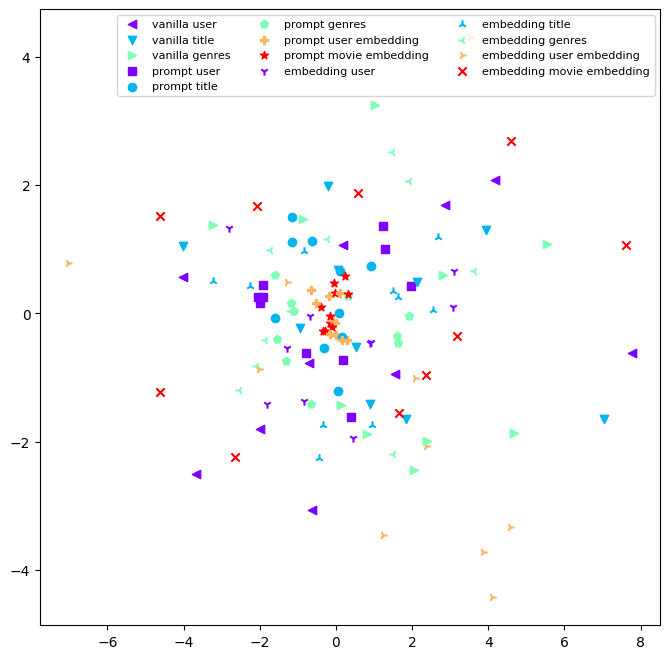

<Figure size 800x800 with 0 Axes>

In [38]:
def filter_by_singular_user(vanilla_df:pd.DataFrame, prompt_df:pd.DataFrame, embedding_df:pd.DataFrame, min_size = 25) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    vanilla_count = vanilla_df['user_id'].value_counts().rename('vanilla_count')
    prompt_count = prompt_df['user_id'].value_counts().rename('prompt_count')
    embedding_count = embedding_df['user_id'].value_counts().rename('embedding_count')
    combined_counts = pd.concat([vanilla_count, prompt_count, embedding_count], axis=1).fillna(0).astype(int).reset_index()
    combined_counts[(combined_counts["vanilla_count"] >= min_size) & (combined_counts["prompt_count"] >= min_size) & (combined_counts["embedding_count"] >= min_size)]
    if not len(combined_counts) > 0:
        raise Exception("There are not enough user_ids matching over all models.")
    singular_user = rd.choice(combined_counts["user_id"].unique())
    return vanilla_df[vanilla_df["user_id"] == singular_user], prompt_df[prompt_df["user_id"] == singular_user], embedding_df[embedding_df["user_id"] == singular_user]

def filter_by_singular_title(vanilla_df:pd.DataFrame, prompt_df:pd.DataFrame, embedding_df:pd.DataFrame, min_size = 25) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    vanilla_count = vanilla_df['title'].value_counts().rename('vanilla_count')
    prompt_count = prompt_df['title'].value_counts().rename('prompt_count')
    embedding_count = embedding_df['title'].value_counts().rename('embedding_count')
    combined_counts = pd.concat([vanilla_count, prompt_count, embedding_count], axis=1).fillna(0).astype(int).reset_index()
    combined_counts[(combined_counts["vanilla_count"] >= min_size) & (combined_counts["prompt_count"] >= min_size) & (combined_counts["embedding_count"] >= min_size)]
    if not len(combined_counts) > 0:
        raise Exception("There are not enough titles matching over all models.")
    singular_title = rd.choice(combined_counts["title"].unique())
    return vanilla_df[vanilla_df["title"] == singular_title], prompt_df[prompt_df["title"] == singular_title], embedding_df[embedding_df["title"] == singular_title]

def plot_hidden_states_with_pca(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df, vanilla_pcas, prompt_pcas, embedding_pcas, n = 1, plot_filters = ['vanilla user', 'vanilla title', 'vanilla genres', 'prompt user', 'prompt title', 'prompt genres', 'prompt user embedding', 'prompt movie embedding', 'embedding user', 'embedding title', 'embedding genres', 'embedding user embedding', 'embedding movie embedding'], singular_user = False, singular_title = False):
    if singular_user:
        vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df = filter_by_singular_user(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df)
    if singular_title:
        vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df = filter_by_singular_title(vanilla_hidden_states_df, prompt_hidden_states_df, embedding_hidden_states_df)
    
    vanilla_hidden_states_df = vanilla_hidden_states_df.sample(n=n).reset_index(drop=False)
    sample_indices = vanilla_hidden_states_df['index']
    vanilla_hidden_states_df = vanilla_hidden_states_df.drop(columns=['index'])
    prompt_hidden_states_df = prompt_hidden_states_df.loc[sample_indices].reset_index(drop=True)
    embedding_hidden_states_df = embedding_hidden_states_df.loc[sample_indices].reset_index(drop=True)


    vanilla_hidden_states = torch.stack(vanilla_hidden_states_df["hidden_states"].tolist()).permute(1,0,2)
    prompt_hidden_states = torch.stack(prompt_hidden_states_df["hidden_states"].tolist()).permute(1,0,2)
    embedding_hidden_states = torch.stack(embedding_hidden_states_df["hidden_states"].tolist()).permute(1,0,2)
    low_dim_reps_vanilla = []
    for pca, last_hidden_states in zip(vanilla_pcas, vanilla_hidden_states):
        low_dim_rep = pca.transform(last_hidden_states)
        low_dim_reps_vanilla.append(low_dim_rep)
    
    low_dim_reps_prompt = []
    for pca, last_hidden_states in zip(prompt_pcas, prompt_hidden_states):
        low_dim_rep = pca.transform(last_hidden_states)
        low_dim_reps_prompt.append(low_dim_rep)
    
    low_dim_reps_embedding = []
    for pca, last_hidden_states in zip(embedding_pcas, embedding_hidden_states):
        low_dim_rep = pca.transform(last_hidden_states)
        low_dim_reps_embedding.append(low_dim_rep)
    
    low_dim_reps_vanilla = np.stack(low_dim_reps_vanilla).transpose((1,0,2))
    low_dim_reps_prompt = np.stack(low_dim_reps_prompt).transpose((1,0,2))
    low_dim_reps_embedding = np.stack(low_dim_reps_embedding).transpose((1,0,2))

    print(low_dim_reps_vanilla.shape, low_dim_reps_prompt.shape)
        
    colors = cm.rainbow(np.linspace(0, 1, 5))
    for low_dim_reps_vanilla_, low_dim_reps_prompt_, low_dim_reps_embedding_ in zip(low_dim_reps_vanilla,low_dim_reps_prompt, low_dim_reps_embedding):
        user_id_embedding_vanilla = low_dim_reps_vanilla_[0]
        title_embedding_vanilla = low_dim_reps_vanilla_[1]
        genres_embedding_vanilla = low_dim_reps_vanilla_[2]

        scatter_legend = []
        if "vanilla user" in plot_filters:
            v_u = plt.scatter([user_id_embedding_vanilla[0]], [user_id_embedding_vanilla[1]], marker="<", color = colors[0])
            scatter_legend.append(v_u)
        if "vanilla title" in plot_filters:
            v_t = plt.scatter([title_embedding_vanilla[0]], [title_embedding_vanilla[1]], marker="v", color = colors[1])
            scatter_legend.append(v_t)
        if "vanilla genres" in plot_filters:
            v_g = plt.scatter([genres_embedding_vanilla[0]], [genres_embedding_vanilla[1]], marker=">", color = colors[2])
            scatter_legend.append(v_g)

        
        user_id_embedding_prompt = low_dim_reps_prompt_[0]
        title_embedding_prompt = low_dim_reps_prompt_[1]
        genres_embedding_prompt = low_dim_reps_prompt_[2]
        user_embedding_embedding_prompt = low_dim_reps_prompt_[3]
        movie_embedding_embedding_prompt = low_dim_reps_prompt_[4]
        if "prompt user" in plot_filters:
            p_u = plt.scatter([user_id_embedding_prompt[0]], [user_id_embedding_prompt[1]], marker="s", color = colors[0])
            scatter_legend.append(p_u)
        if "prompt title" in plot_filters:
            p_t = plt.scatter([title_embedding_prompt[0]], [title_embedding_prompt[1]], marker="o", color = colors[1])
            scatter_legend.append(p_t)
        if "prompt genres" in plot_filters:
            p_g = plt.scatter([genres_embedding_prompt[0]], [genres_embedding_prompt[1]], marker="p", color = colors[2])
            scatter_legend.append(p_g)
        if "prompt user embedding" in plot_filters:
            p_ue = plt.scatter([user_embedding_embedding_prompt[0]], [user_embedding_embedding_prompt[1]], marker="P", color = colors[3])
            scatter_legend.append(p_ue)
        if "prompt movie embedding" in plot_filters:
            p_me = plt.scatter([movie_embedding_embedding_prompt[0]], [movie_embedding_embedding_prompt[1]], marker="*", color = colors[4])
            scatter_legend.append(p_me)
        
        
        user_id_embedding_embedding = low_dim_reps_embedding_[0]
        title_embedding_embedding = low_dim_reps_embedding_[1]
        genres_embedding_embedding = low_dim_reps_embedding_[2]
        user_embedding_embedding_embedding = low_dim_reps_embedding_[3]
        movie_embedding_embedding_embedding = low_dim_reps_embedding_[4]
        if "embedding user" in plot_filters:
            e_u = plt.scatter([user_id_embedding_embedding[0]], [user_id_embedding_embedding[1]], marker="1", color = colors[0])
            scatter_legend.append(e_u)
        if "embedding title" in plot_filters:
            e_t = plt.scatter([title_embedding_embedding[0]], [title_embedding_embedding[1]], marker="2", color = colors[1])
            scatter_legend.append(e_t)
        if "embedding genres" in plot_filters:
            e_g = plt.scatter([genres_embedding_embedding[0]], [genres_embedding_embedding[1]], marker="3", color = colors[2])
            scatter_legend.append(e_g)
        if "embedding user embedding" in plot_filters:
            e_ue = plt.scatter([user_embedding_embedding_embedding[0]], [user_embedding_embedding_embedding[1]], marker="4", color = colors[3])
            scatter_legend.append(e_ue)
        if "embedding movie embedding" in plot_filters:
            e_me = plt.scatter([movie_embedding_embedding_embedding[0]], [movie_embedding_embedding_embedding[1]], marker="x", color = colors[4])
            scatter_legend.append(e_me)
    plt.legend(scatter_legend,
            plot_filters,
            scatterpoints=1,
            loc='upper right',
            ncol=3,
            fontsize=8,)
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    plt.figure(figsize=(8, 8), dpi=100)
    plt.show()

    
n = 10
all_filters = ['vanilla user', 'vanilla title', 'vanilla genres', 'prompt user', 'prompt title', 'prompt genres', 'prompt user embedding', 'prompt movie embedding', 'embedding user', 'embedding title', 'embedding genres', 'embedding user embedding', 'embedding movie embedding']
only_user_filters = ['vanilla user', 'prompt user', 'embedding user']
only_title_filters = ['vanilla title', 'prompt title', 'embedding title']
only_genres_filters = ['vanilla genres', 'prompt genres', 'embedding genres']
user_title_filters = ['vanilla user', 'vanilla title', 'prompt user', 'prompt title', 'embedding user', 'embedding title']
embedding_filters = ['prompt user embedding', 'prompt movie embedding', 'embedding user embedding', 'embedding movie embedding']
vanilla_filters =  ['vanilla user', 'vanilla title', 'vanilla genres','prompt user', 'prompt title', 'prompt genres','embedding user', 'embedding title', 'embedding genres']
plot_filters = all_filters
singular_user = False
singular_title = False
plot_hidden_states_with_pca(vanilla_hidden_states_df, prompt_hidden_states_df, adding_embedding_hidden_states_df, vanilla_pcas, prompt_pcas, adding_embedding_pcas, n = n, plot_filters = plot_filters, singular_user=singular_user, singular_title=singular_title)